### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

### Data Preprocessing

In [2]:
# Read the full dataset
df = pd.read_csv("tree_loss.csv")

# Filter threshold == 30
df = df[df['threshold'] == 30]

# State-level data
df_state = df[(df['subnational1'].notna()) & (df['subnational2'].isna())]
# Remove East Malaysia entries
df_state = df_state[~df_state['subnational1'].str.lower().isin(['sabah', 'sarawak', 'labuan', 'putrajaya'])]
# Drop 'country' and 'subnational2' columns
df_state = df_state.drop(columns=['country', 'subnational2'])
# Rename subnational1 to state
df_state = df_state.rename(columns={'subnational1': 'state'})
# Rename Trengganu to Terengganu
df_state['state'] = df_state['state'].replace({'Trengganu': 'Terengganu'})
# Sort values
df_state = df_state.sort_values(['state', 'year'])

# District-level data
df_district = df[(df['subnational1'].notna()) & (df['subnational2'].notna())]
# Remove East Malaysia entries
df_district = df_district[~df_district['subnational1'].str.lower().isin(['sabah', 'sarawak', 'labuan', 'putrajaya'])]
# Drop 'country' column
df_district = df_district.drop(columns=['country'])
# Rename subnational1 to state, subnational2 to district
df_district = df_district.rename(columns={'subnational1': 'state', 'subnational2': 'district'})
# Rename Trengganu to Terengganu
df_district['state'] = df_district['state'].replace({'Trengganu': 'Terengganu'})
# Sort values
df_district = df_district.sort_values(['state', 'district', 'year'])

# Save to CSV
df_state.to_csv("tree_loss_state.csv", index=False)
df_district.to_csv("tree_loss_district.csv", index=False)

### Load Data

In [3]:
# Load datasets
df_state = pd.read_csv("tree_loss_state.csv")
df_district = pd.read_csv("tree_loss_district.csv")

### Exploratory Data Analysis

#### Visualise Tree Cover Loss by State and Year

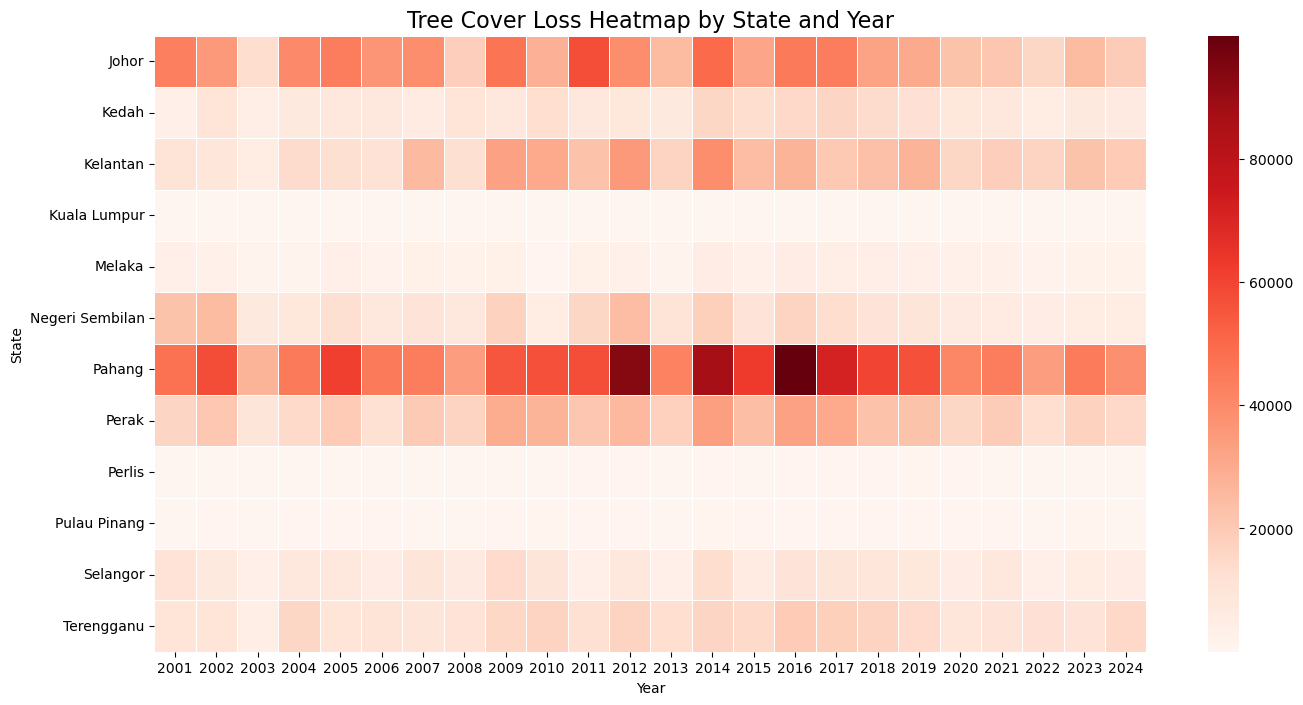

In [4]:
state_pivot = df_state.pivot(index="state", columns="year", values="tc_loss_ha")

plt.figure(figsize=(16,8))
sns.heatmap(state_pivot, cmap="Reds", linewidths=0.5)
plt.title("Tree Cover Loss Heatmap by State and Year", fontsize=16)
plt.xlabel("Year")
plt.ylabel("State")
plt.show()

#### Visualise Tree Cover Loss by District and Year

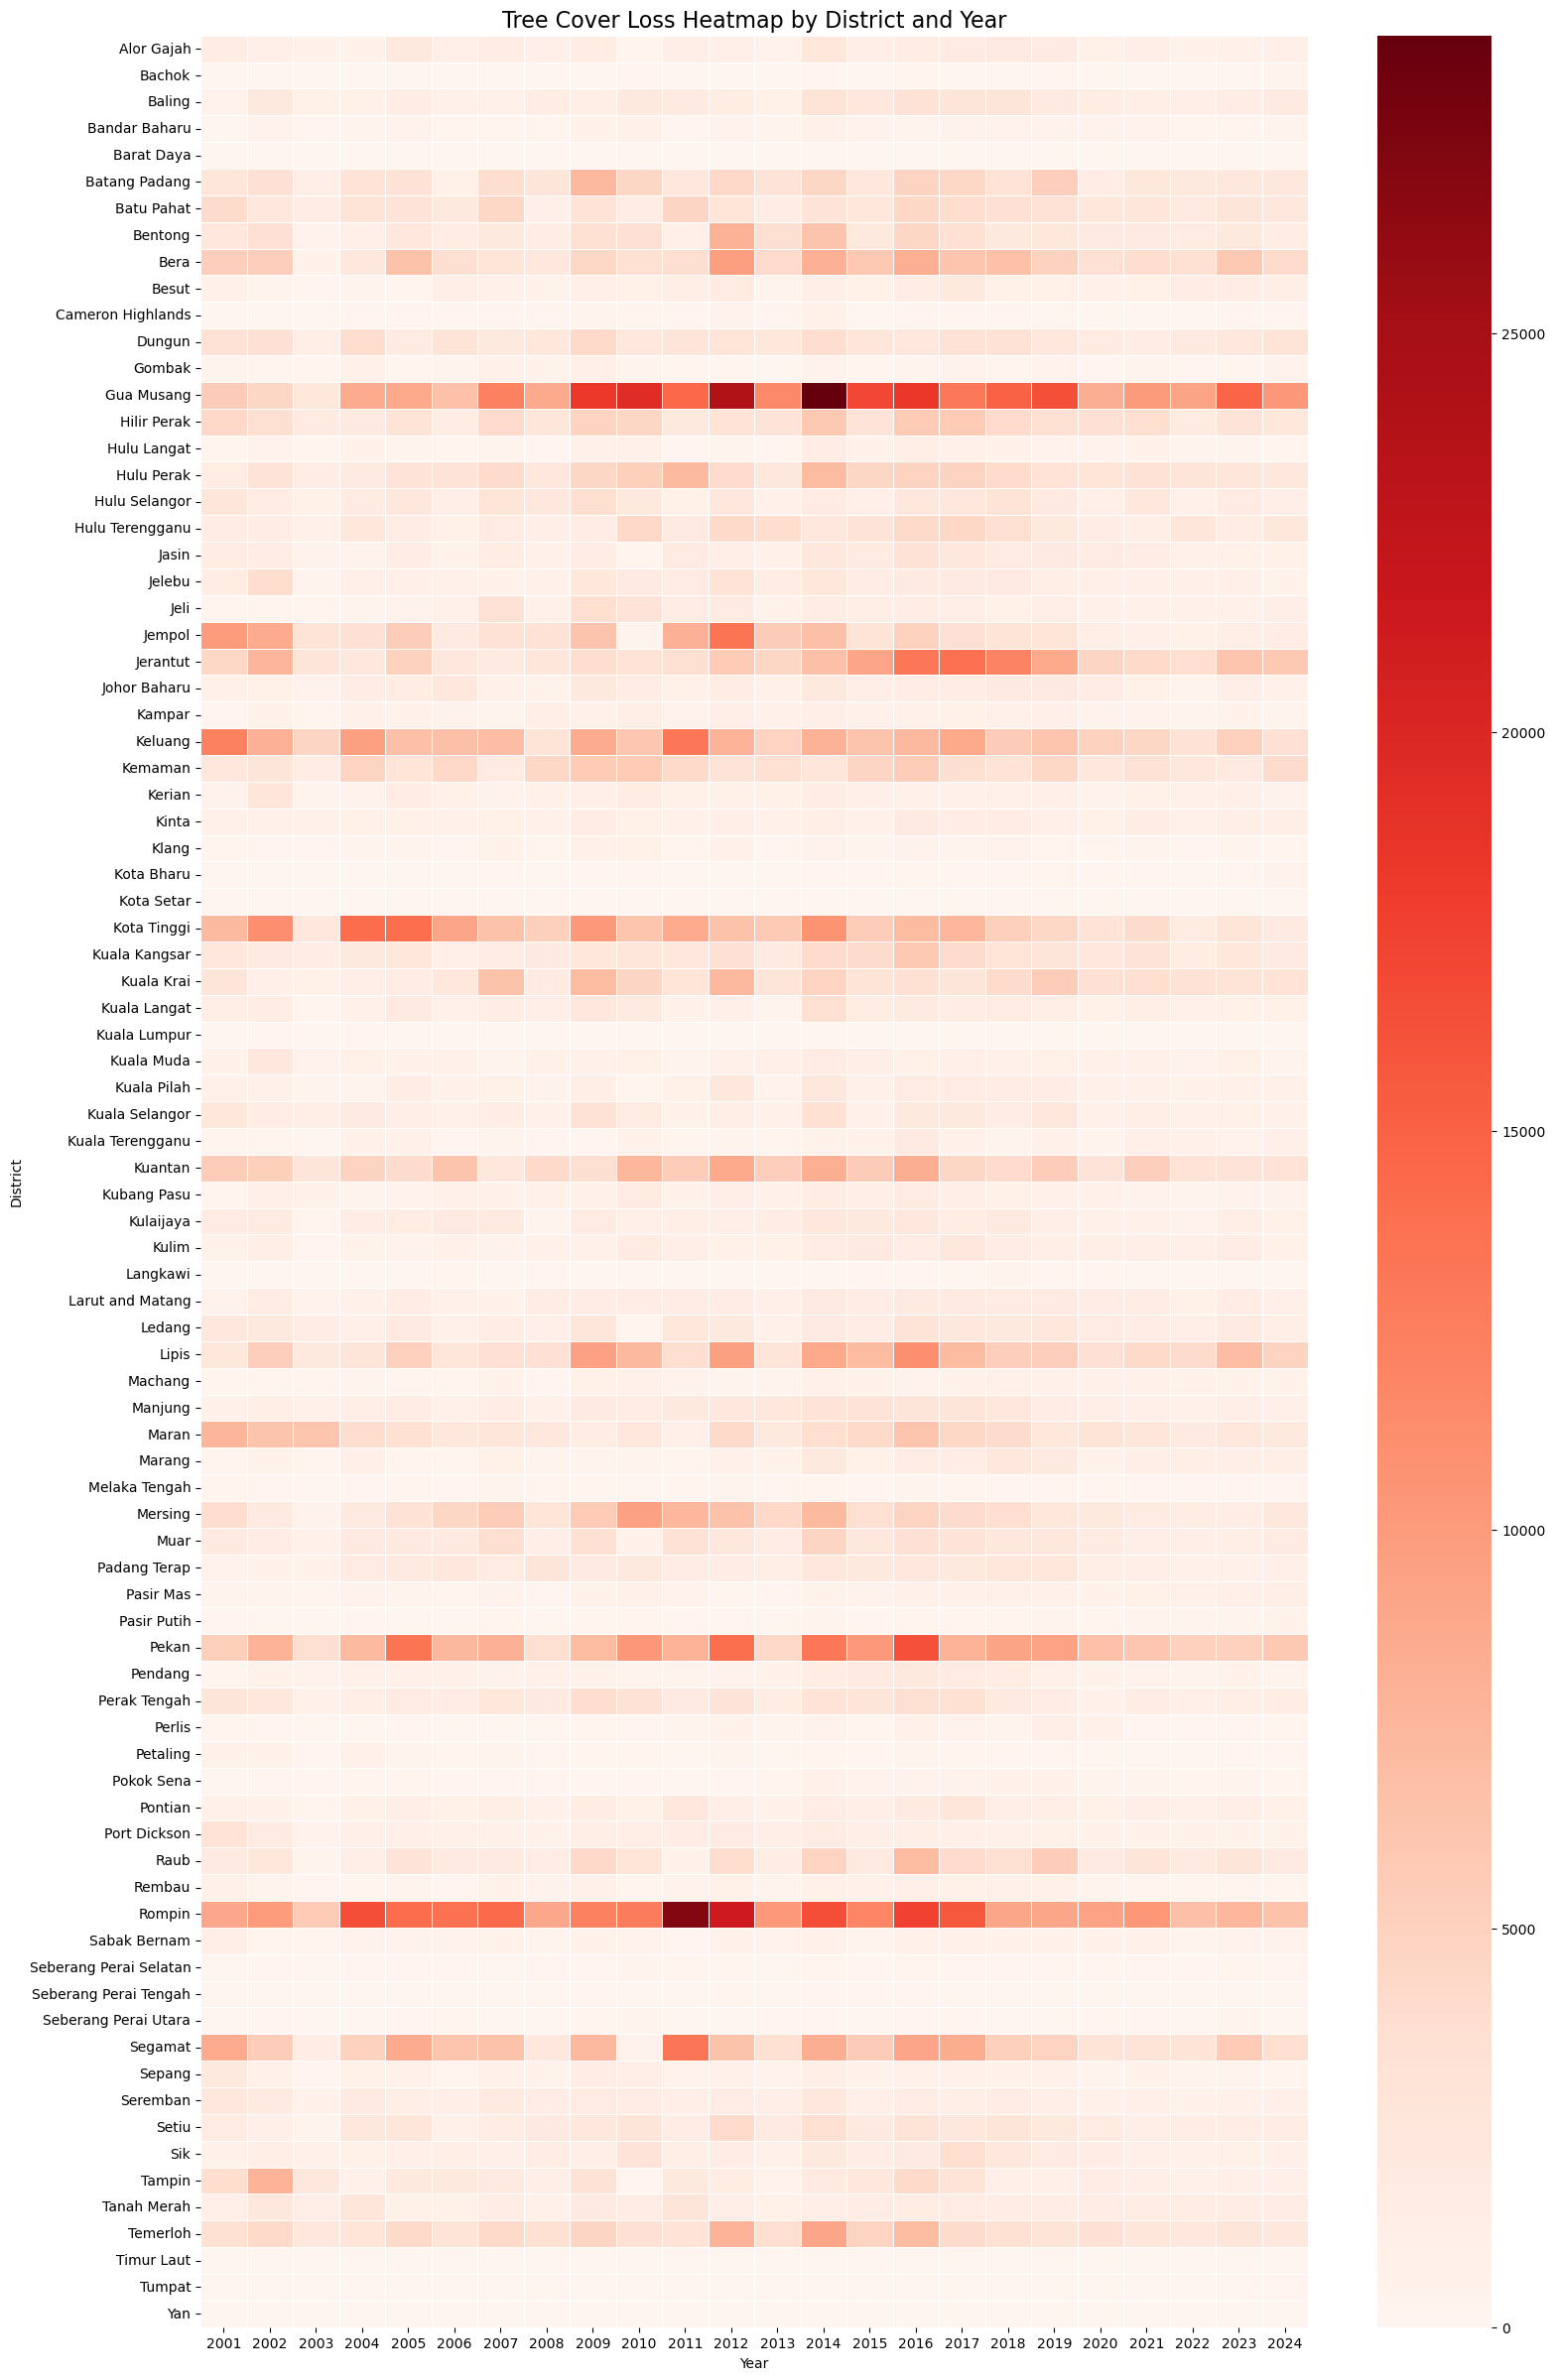

In [5]:
district_pivot = df_district.pivot(index="district", columns="year", values="tc_loss_ha")

plt.figure(figsize=(18,30))
sns.heatmap(district_pivot, cmap="Reds", linewidths=0.5)
plt.title("Tree Cover Loss Heatmap by District and Year", fontsize=16)
plt.xlabel("Year")
plt.ylabel("District")
plt.show()

### Feature Engineering

In [6]:
# Percentage change from previous year
df_district['pct_change'] = df_district.groupby(['state','district'])['tc_loss_ha'].pct_change() * 100

# Replace infinity values with NaN
df_district['pct_change'] = df_district['pct_change'].replace([np.inf, -np.inf], np.nan)

# Define lag years: Use previous year(s) to predict current year
lag_years = range(1, 2) 

# Create lag features
for lag in lag_years:
    df_district[f'lag_{lag}'] = df_district.groupby(['state','district'])['tc_loss_ha'].shift(lag)

### Train / Test Split

In [7]:
# Define train and test years
train_years = list(range(2001+max(lag_years), 2021))  # 2002-2020
test_years = list(range(2021, 2025))                  # 2021-2024

# Split into train/test set
train_df = df_district[df_district['year'].isin(train_years)]
test_df = df_district[df_district['year'].isin(test_years)]

# Features and target
feature_cols = ['pct_change'] + [f'lag_{lag}' for lag in lag_years]
target_col = 'tc_loss_ha'

# Drop rows with NaN values
train_df = train_df.dropna(subset=feature_cols + [target_col])
test_df = test_df.dropna(subset=feature_cols + [target_col])

# Prepare x and y
x_train = train_df[feature_cols]
y_train = train_df[target_col]
x_test = test_df[feature_cols]
y_test = test_df[target_col]

# Print shapes
print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)

Train Shape: (1631, 7)
Test Shape: (341, 7)


### Model Training and Testing

#### Random Forest

In [8]:
# Train
model = RandomForestRegressor(n_estimators=200, random_state=7)
model.fit(x_train, y_train)

# Test
y_pred = model.predict(x_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred) 
mape = (np.abs((y_test - y_pred) / y_test).replace([np.inf, -np.inf], np.nan)).mean() * 100    # mean(|y - y_hat| / y|)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:.2f} hectares ")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}% ")

Mean Absolute Error (MAE): 29.94 hectares 
Mean Absolute Percentage Error (MAPE): 2.85% 


##### Detailed Evaluation

In [9]:
# Attach predictions back into test_df
test_df = test_df.copy()
test_df['tc_loss_pred'] = y_pred

# District-level metrics
district_metrics = []

for dist, df_dist in test_df.groupby('district'):
    y_true = df_dist['tc_loss_ha']
    y_hat = df_dist['tc_loss_pred']

    mae = mean_absolute_error(y_true, y_hat)
    mape = (np.abs((y_true - y_hat) / y_true).replace([np.inf, -np.inf], np.nan)).mean() * 100

    district_metrics.append({
        "state": df_dist['state'].iloc[0],
        "district": dist,
        "MAE": mae,
        "MAPE": mape,
    })

district_metrics_df = pd.DataFrame(district_metrics)
district_metrics_df = district_metrics_df.sort_values(["state", "district"]).reset_index(drop=True)
district_metrics_df = district_metrics_df.round(2)
district_metrics_df.to_csv("metrics_district.csv", index=False)


# State-level metrics (Aggregated by summing districts)
state_metrics = []

for state, df_state in test_df.groupby("state"):
    df_yearly = df_state.groupby("year")[["tc_loss_ha", "tc_loss_pred"]].sum().reset_index()

    y_true = df_yearly['tc_loss_ha']
    y_hat = df_yearly['tc_loss_pred']

    mae = mean_absolute_error(y_true, y_hat)
    mape = (np.abs((y_true - y_hat) / y_true).replace([np.inf, -np.inf], np.nan)).mean() * 100

    state_metrics.append({
        "state": state,
        "MAE": mae,
        "MAPE": mape,
    })

state_metrics_df = pd.DataFrame(state_metrics)
state_metrics_df = state_metrics_df.sort_values("state").reset_index(drop=True)
state_metrics_df = state_metrics_df.round(2)
state_metrics_df.to_csv("metrics_state.csv", index=False)


# Print Error Distribution Summary
bins = [0, 10, 20, 50, np.inf]
labels = ["≤ 10%", "> 10% and ≤ 20%", "> 20% and ≤ 50%", "> 50%"]

# District-level
district_counts_mae = pd.cut(district_metrics_df["MAPE"], bins=bins, labels=labels).value_counts().sort_index()
district_counts_mae.index.name = None
print("=== District-level MAPE Distribution Summary ===")
print(district_counts_mae.to_string())

# State-level
state_counts_mae = pd.cut(state_metrics_df["MAPE"], bins=bins, labels=labels).value_counts().sort_index()
state_counts_mae.index.name = None
print("\n=== State-level MAPE Distribution Summary ===")
print(state_counts_mae.to_string())

=== District-level MAPE Distribution Summary ===
≤ 10%              82
> 10% and ≤ 20%     2
> 20% and ≤ 50%     2
> 50%               0

=== State-level MAPE Distribution Summary ===
≤ 10%              12
> 10% and ≤ 20%     0
> 20% and ≤ 50%     0
> 50%               0


### Model Prediction

In [10]:
# Years to forecast
future_years = list(range(2025, 2031))

# Copy last known data for each district to start forecasts
future_df = df_district[df_district['year'] == 2024].copy()

# List to hold predictions
predictions = []

# Iterate over each future year
for year in future_years:
    # Features
    x_future = future_df[['pct_change'] + [f'lag_{lag}' for lag in lag_years]]
    
    # Predict
    y_future = model.predict(x_future)
    
    # Save predictions
    temp = future_df[['state','district']].copy()
    temp['year'] = year
    temp['tc_loss_pred'] = y_future
    predictions.append(temp)
    
    # Update lags
    for lag in reversed(lag_years):
        if lag == 1:
            future_df[f'lag_{lag}'] = y_future  # New prediction becomes lag_1
        else:
            future_df[f'lag_{lag}'] = future_df[f'lag_{lag-1}']  # Shift
    
    # Update pct_change
    prev = future_df['lag_1']  # Last known / Predicted value
    future_df['pct_change'] = ((y_future - prev) / prev) * 100
    
# Combine all predictions
district_future_df = pd.concat(predictions, ignore_index=True)

# Sort by state, district, year
district_future_df = district_future_df.sort_values(by=["state", "district", "year"]).reset_index(drop=True)

# Aggregate to state-level
state_future_df = (district_future_df.groupby(["state", "year"], as_index=False)["tc_loss_pred"].sum())

# Save to CSV
district_future_df.to_csv("tree_loss_district_predictions.csv", index=False)
state_future_df.to_csv("tree_loss_state_predictions.csv", index=False)

### Naive Baseline

In [11]:
# Predict last year's value (lag_1)
test_df_naive = test_df.copy()
test_df_naive['tc_loss_pred'] = test_df_naive['lag_1']

# Drop rows where lag_1 is missing
test_df_naive = test_df_naive.dropna(subset=['tc_loss_pred'])

# Evaluate
mae_naive = mean_absolute_error(test_df_naive['tc_loss_ha'], test_df_naive['tc_loss_pred'])
mape_naive = (np.abs((test_df_naive['tc_loss_ha'] - test_df_naive['tc_loss_pred']) / test_df_naive['tc_loss_ha'])).mean() * 100

# Print metrics
print(f"Mean Absolute Error (MAE): {mae_naive:.2f} hectares ")
print(f"Mean Absolute Percentage Error (MAPE): {mape_naive:.2f}% ")

Mean Absolute Error (MAE): 409.77 hectares 
Mean Absolute Percentage Error (MAPE): 35.27% 


In [12]:
# District-level metrics
district_metrics_naive = []

for dist, df_dist in test_df_naive.groupby('district'):
    y_true = df_dist['tc_loss_ha']
    y_hat = df_dist['tc_loss_pred']

    mae_naive = mean_absolute_error(y_true, y_hat)
    mape_naive = (np.abs((y_true - y_hat) / y_true)).mean() * 100

    district_metrics_naive.append({
        "state": df_dist['state'].iloc[0],
        "district": dist,
        "MAE": mae_naive,
        "MAPE": mape_naive,
    })

district_metrics_naive_df = pd.DataFrame(district_metrics_naive)
district_metrics_naive_df = district_metrics_naive_df.sort_values(["state", "district"]).reset_index(drop=True)
district_metrics_naive_df = district_metrics_naive_df.round(2)
district_metrics_naive_df.to_csv("metrics_district_naive.csv", index=False)


# State-level metrics (Aggregated by summing districts)
state_metrics_naive = []

for state, df_state in test_df_naive.groupby("state"):
    df_yearly = df_state.groupby("year")[["tc_loss_ha", "tc_loss_pred"]].sum().reset_index()

    y_true = df_yearly['tc_loss_ha']
    y_hat = df_yearly['tc_loss_pred']

    mae_naive = mean_absolute_error(y_true, y_hat)
    mape_naive = (np.abs((y_true - y_hat) / y_true)).mean() * 100

    state_metrics_naive.append({
        "state": state,
        "MAE": mae_naive,
        "MAPE": mape_naive,
    })

state_metrics_naive_df = pd.DataFrame(state_metrics_naive)
state_metrics_naive_df = state_metrics_naive_df.sort_values("state").reset_index(drop=True)
state_metrics_naive_df = state_metrics_naive_df.round(2)
state_metrics_naive_df.to_csv("metrics_state_naive.csv", index=False)


# Print Error Distribution Summary
bins = [0, 10, 20, 50, np.inf]
labels = ["≤ 10%", "> 10% and ≤ 20%", "> 20% and ≤ 50%", "> 50%"]

# District-level
district_counts_mae = pd.cut(district_metrics_naive_df["MAPE"], bins=bins, labels=labels).value_counts().sort_index()
district_counts_mae.index.name = None
print("=== District-level MAPE Distribution Summary (Naive) ===")
print(district_counts_mae.to_string())

# State-level
state_counts_mae = pd.cut(state_metrics_naive_df["MAPE"], bins=bins, labels=labels).value_counts().sort_index()
state_counts_mae.index.name = None
print("\n=== State-level MAPE Distribution Summary (Naive) ===")
print(state_counts_mae.to_string())

=== District-level MAPE Distribution Summary (Naive) ===
≤ 10%               4
> 10% and ≤ 20%    20
> 20% and ≤ 50%    45
> 50%              17

=== State-level MAPE Distribution Summary (Naive) ===
≤ 10%              0
> 10% and ≤ 20%    5
> 20% and ≤ 50%    5
> 50%              2
